# Исследования данных по посещению сайта Яндекс.Афиша

В данной работе нам необходимо рассмотреть маркетинговые источники сайта Яндекс.Афиша и определить их эффективность. <p>
В нашем распоряжении  данные Яндекс.Афиши с июня 2017 по конец мая 2018 года: 
    - лог сервера с данными о посещениях сайта Яндекс.Афиши,
    - выгрузка всех заказов за этот период, 
    - статистика рекламных расходов

## Шаг 1.1  Подготовка данных к анализу

<b> Загрузим данные о визитах пользователей, заказах и рекламных расходах</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### Таблица Visits

In [3]:
display(visits.head())

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

В таблице визитов пользователей мы видим следующие данные:
- тип устройства, с которого заходил пользователь
- время начала сессии
- время окончания сессии
- уникальный номер пользователя
- уникаольный номер ресурса, с которого зашел пользователь

Посмотрим подробную информацию по таблице

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
print('Количество дубликатов:', visits.duplicated().sum())

Количество дубликатов: 0


Пропусков в таблице нет, дубликатов тоже. 
Однако необходимо изменить тип данных в столбцах со временем, а так же немного скорректируем названия столбцов - для удобства напишем их с маленькой буквы.

In [6]:
#корректируем названия столбцов
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

#переведем тип данных в нужный формат
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [7]:
#проверяем
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


### Таблица Orders

In [8]:
display(orders.head())

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

В таблице заказов мы видим следующие данные:
- время совершения покупки
- сумма покупки
- уникальный номер пользователя

Посмотрим подробную информацию по таблице

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [10]:
print('Количество дубликатов:', orders.duplicated().sum())

Количество дубликатов: 0


Здесь тоже самое: пропусков в таблице нет, дубликатов тоже. 
Изменим тип данных в столбцах со временем, а так же скорректируем названия столбцов.

In [11]:
#корректируем названия столбцов
orders.columns = ['buy_ts', 'revenue', 'uid']

#переведем тип данных в нужный формат
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

#проверяем
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


### Таблица Costs

Проделаем то же самое с последней таблицей.

In [12]:
display(costs.head())

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

В таблице с расходами на рекламу мы видим сумму расходов и дату.
С названиями столбцов здесь все хорошо, проверим типы данных и пропуски.

In [13]:
costs.info()
print('Количество дубликатов:', costs.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
Количество дубликатов: 0


In [14]:
#переведем тип данных
costs['dt'] = pd.to_datetime(costs['dt'])

#проверяем
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


## Шаг 2. Рассчет метрик

### Продуктовые метрики

#### Метрики DAU, WAU и MAU

In [15]:
#добавим в таблицу столбцы с номерами дней, недели и месяца для расчета метрик

visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
display(visits.head()) 


device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  session_year  session_month  session_week  \
0  16879256277535980062          2017             12            51   
1    104060357244891740          2018              2             8   
2   7459035603376831527          2017              7            26   
3  16174680259334210214          2018              5            20   
4   9969694820036681168          2017             12            52   

  session_date  
0   2017-12-20  
1   2018-02-19  
2   2017-07-01  
3   2018-05-20  
4   2017-12-27

In [16]:
#посчитаем метрики
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()


In [17]:
print('Величина DAU, количество пользователей в день - ', int(dau_total))
print('Величина WAU, количество пользователей в неделю - ', int(wau_total))
print('Величина MAU, количество пользователей в месяц - ', int(mau_total))

Величина DAU, количество пользователей в день -  907
Величина WAU, количество пользователей в неделю -  5716
Величина MAU, количество пользователей в месяц -  23228


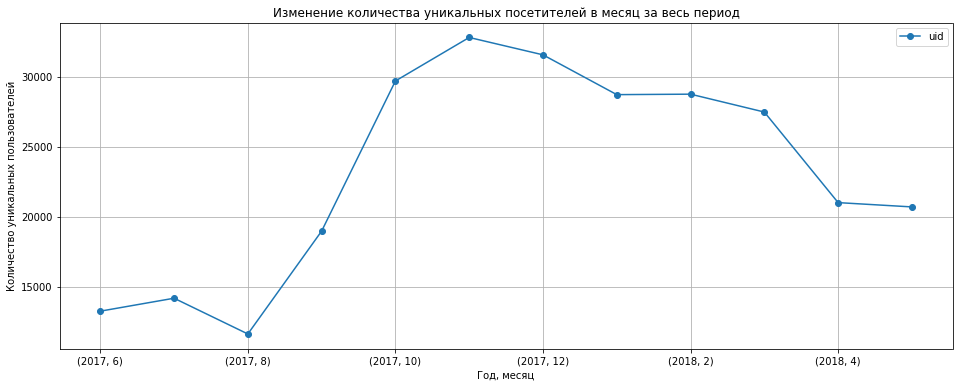

In [18]:
#для наглядности построим график изменения количества пользователей по месяцам
visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).plot(kind='line', style = '-o', y='uid',
                                                                               grid=True, figsize=(16, 6))
plt.xlabel('Год, месяц')
plt.ylabel('Количество уникальных пользователей')
plt.title('Изменение количества уникальных посетителей в месяц за весь период')
plt.show()

Из графика мы видим, что до ноября 2017года количество пользователей каждый месяц возрастало, однако после ноября 2017 года, количество пользователей начало снижаться

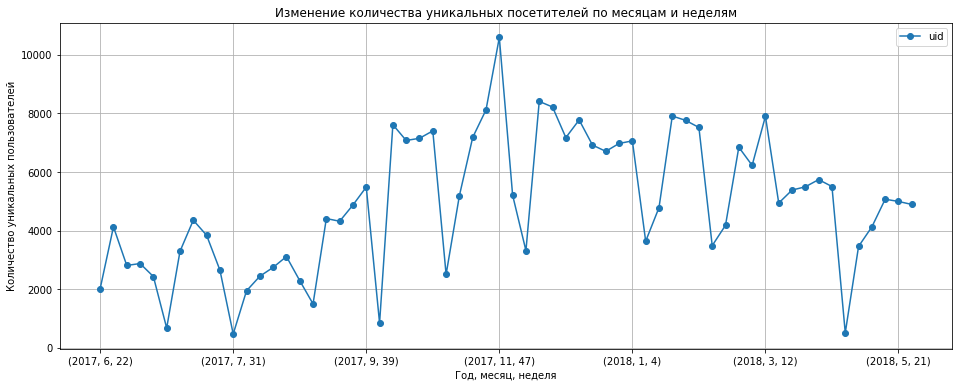

In [19]:
#для наглядности построим график изменения количества пользователей по месяцам и неделям
visits.groupby(['session_year','session_month', 'session_week']).agg({'uid': 'nunique'}).plot(kind='line', style = '-o', y='uid',
                                                                               grid=True, figsize=(16, 6))
plt.xlabel('Год, месяц, неделя')
plt.ylabel('Количество уникальных пользователей')
plt.title('Изменение количества уникальных посетителей по месяцам и неделям')
plt.show()

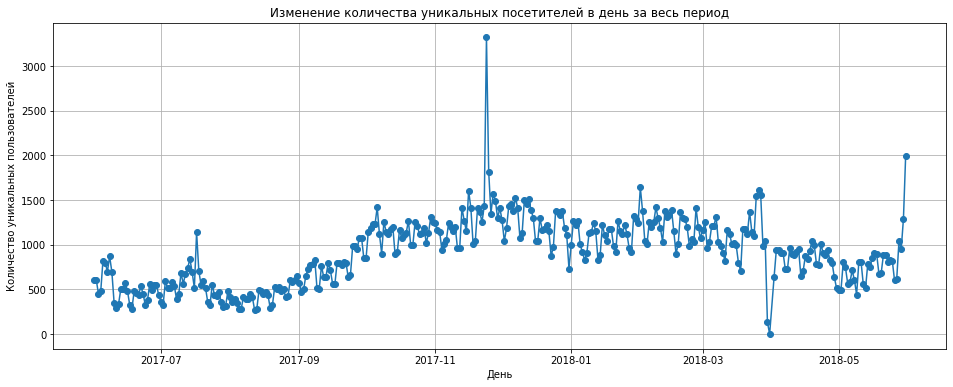

In [20]:
#для наглядности построим график изменения количества пользователей дням
visits.groupby('session_date')['uid'].nunique().plot(kind='line', style = '-o', y='uid', grid=True, figsize=(16, 6))
plt.xlabel('День')
plt.ylabel('Количество уникальных пользователей')
plt.title('Изменение количества уникальных посетителей в день за весь период')
plt.show()

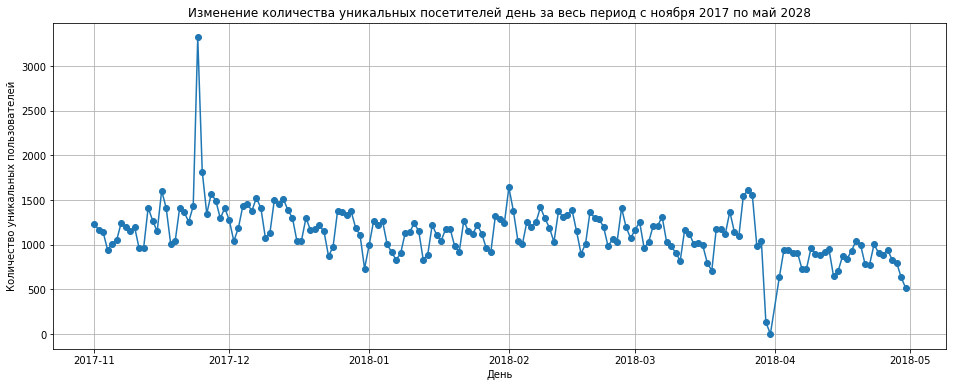

In [21]:
#увеличим график распределения пользователей по дням
visits1 = visits[visits['start_ts'] > '2017-11-01']
visits2 = visits1[visits1['start_ts'] < '2018-05-01']
#display(visits2)

visits2.groupby('session_date')['uid'].nunique().plot(kind='line', style = '-o', y='uid', grid=True, figsize=(16, 6))
plt.xlabel('День')
plt.ylabel('Количество уникальных пользователей')
plt.title('Изменение количества уникальных посетителей день за весь период с ноября 2017 по май 2028')
plt.show()

По графикам мы видим, что есть резкие взлеты и падения.
Взлет перед Новым годом вполне объясним предпраздничными покупками, но падение в апреле в 2018 году довольно необычное. Попробуем проверить таблицу расходов на рекламу, вдруг падение связано с этой причиной

In [22]:
costs.head()

source_id         dt  costs
0          1 2017-06-01  75.20
1          1 2017-06-02  62.25
2          1 2017-06-03  36.53
3          1 2017-06-04  55.00
4          1 2017-06-05  57.08

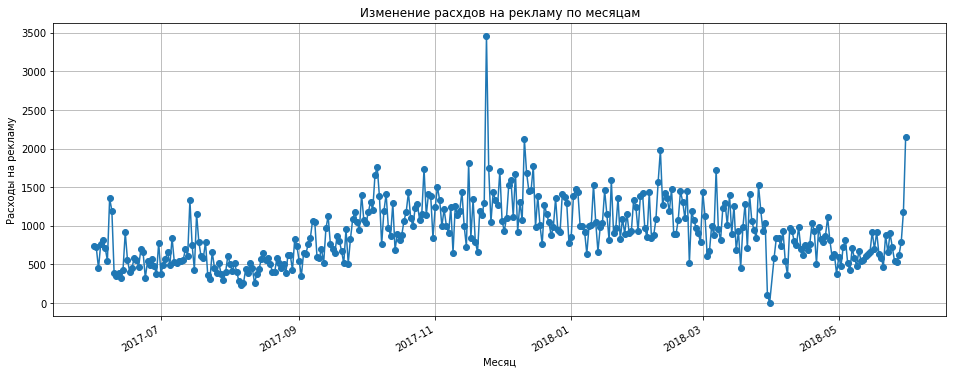

In [23]:
costs.groupby('dt')['costs'].sum().plot(kind='line', style = '-o', y='costs',grid=True, figsize=(16, 6))
plt.xlabel('Месяц')
plt.ylabel('Расходы на рекламу')
plt.title('Изменение расхдов на рекламу по месяцам')
plt.show()

Удивительно, но график расходов по месяцам визуально очень напоминает график с визитами пользователей по месяцам. Сделаем аналогичный гарифк по дням.

In [24]:
#запишем данные из таблицы с расходами в одтельный дата фрейм, чтобы добавить столбцы с днями и неделями
costs_for_dau = costs
costs_for_dau['session_week'] =  costs_for_dau['dt'].dt.week
costs_for_dau['session_date'] =  costs_for_dau['dt'].dt.date
#costs_for_dau.head()

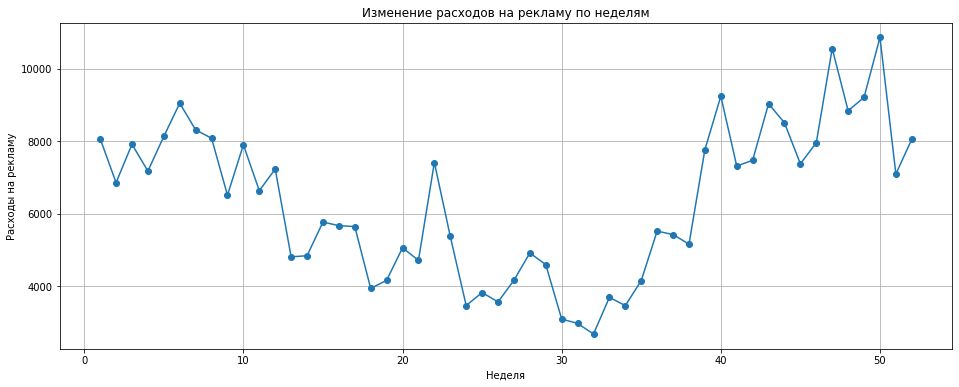

In [25]:
costs_for_dau.groupby('session_week')['costs'].sum().plot(kind='line', style = '-o', y='costs',
                                                                                                             grid=True, figsize=(16, 6))

plt.xlabel('Неделя')
plt.ylabel('Расходы на рекламу')
plt.title('Изменение расходов на рекламу по неделям')
plt.show()

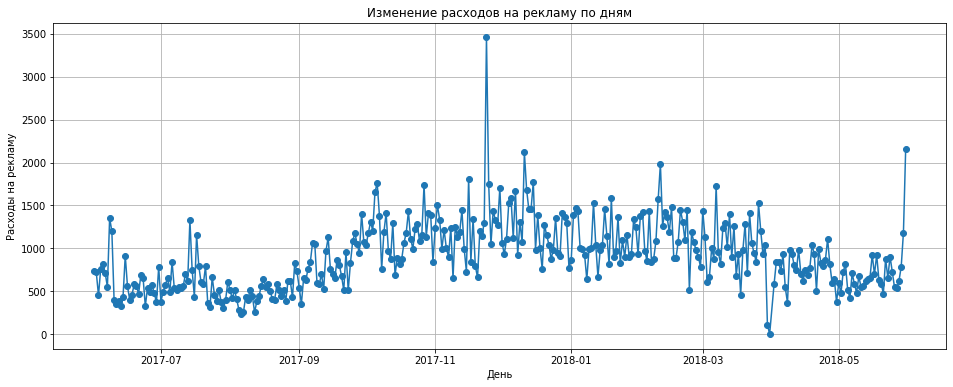

In [26]:
costs.groupby('session_date')['costs'].sum().plot(kind='line', style = '-o', y='costs', grid=True, figsize=(16, 6))


plt.xlabel('День')
plt.ylabel('Расходы на рекламу')
plt.title('Изменение расходов на рекламу по дням')
plt.show()

Ну вот, мы нашли причину. График расходов по дням очень напоминает график посещения пользователями по дням. На графике мы видим такой же пик в декабре 2017 и такой же провал в апреле 2018. Можно сделать вывод, что количество визитов пользователей прямопропорционально количеству расходов на рекламу.

#### Посчитаем как часто пользователь пользуется сайтом

Рассчитаем метрику <b> sticky factor </b>

In [27]:
#расчет метрики sticky factor = DAU/WAU
sticky_factor = dau_total / wau_total * 100
sticky_factor_2 = dau_total / mau_total * 100
print('Вовлеченность пользователей за неделю - ', int(sticky_factor), '%')
print('Вовлеченность пользователей за месяц - ', int(sticky_factor_2), '%')

Вовлеченность пользователей за неделю -  15 %
Вовлеченность пользователей за месяц -  3 %


<b>Среднее количество сессий на одного пользователя</b>

In [28]:
#рассчитаем как сколько сессий в среднем приходится на одного пользователя
sessions_per_user = visits.groupby(['session_year', 'session_month']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['session_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
display(sessions_per_user)

n_sessions  n_users  session_per_user
session_year session_month                                       
2017         6                   16505    13259          1.244815
             7                   17828    14183          1.256998
             8                   14355    11631          1.234202
             9                   23907    18975          1.259921
             10                  37903    29692          1.276539
             11                  43969    32797          1.340641
             12                  41983    31557          1.330386
2018         1                   36939    28716          1.286356
             2                   37182    28749          1.293332
             3                   35679    27473          1.298693
             4                   26515    21008          1.262138
             5                   26635    20701          1.286653

Из таблицы мы видим, что среднее количество сессий на одного пользователя примерно одинаковое в течение всего периода.
Так же видно, что количество пользователей с июня 2017 года растет к декабря 2017, но с января 2018 по май 2018 постепенно уменьшается.

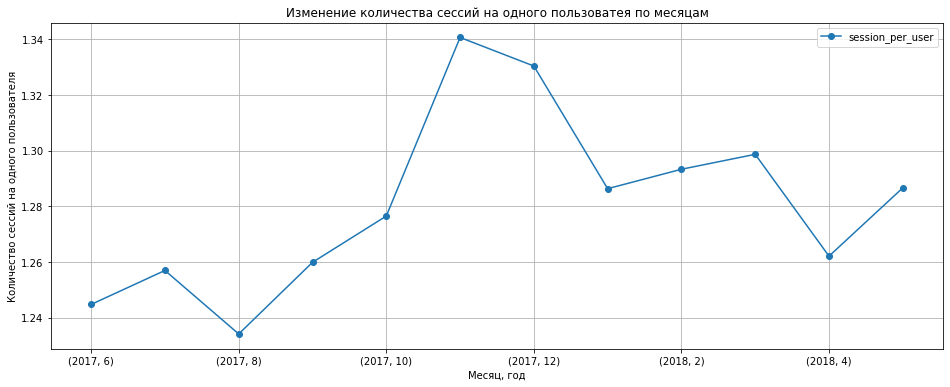

In [29]:
sessions_per_user.plot(kind='line', style = '-o', y='session_per_user', grid=True, figsize=(16, 6))
plt.xlabel('Месяц, год')
plt.ylabel('Количество сессий на одного пользователя')
plt.title('Изменение количества сессий на одного пользоватея по месяцам')
plt.show()

По графику можно сделать дополнительный вывод: изменения среднего количества сессий на одного пользователя колеблется примерно так же, как и общее количество пользовательских визитов на сайт, и так же как изменение расходов на рекламу, поскольку есть такой же резкий рост к декабрю 2017 и такой же резкий провал в апреле 2017

#### Исследование продолжительности пользовательской сессии, метрика ASL

In [30]:
#посчитаем длину всех сессий и вычислим среднее
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Пользователи в среднем проводят на сайте', visits['session_duration_sec'].mean().round(), 'секунд')


Пользователи в среднем проводят на сайте 644.0 секунд


Посмотрим на распределение:

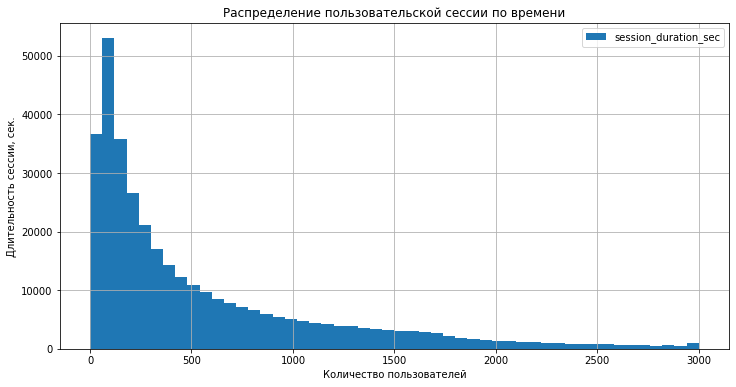

In [31]:
visits.plot(y = 'session_duration_sec', kind = 'hist', bins = 50, grid = True, figsize = (12, 6), range = (0, 3000)) 
plt.xlabel('Количество пользователей')
plt.ylabel('Длительность сессии, сек.')
plt.title('Распределение пользовательской сессии по времени')
plt.show()

Распределение не похоже на нормальное, поэтому рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [32]:
print(visits['session_duration_sec'].mode()) 

0    60
dtype: int64


Таким образом, чаще всего, пользователь проводит на сайте 60 секунд. Если за это время он успевает оформить заказ, то все в порядке

#### Метрика Retention Rate

Рассчитаем метрику Retention Rate - коэффициент удержания пользователя

In [33]:
#найдем время первого визита каждого пользователя
first_activity_date = visits.groupby(['uid'])['start_ts'].min().reset_index()

#переименуем столбцы
first_activity_date.columns = ['uid', 'first_visit'] 

#проверяем
#display(first_activity_date.head())

#объединим таблицы
visits_for_retention_rate = visits.merge(first_activity_date,on='uid')

#добавим месяц первого посещения
visits_for_retention_rate['first_visit_month'] = visits_for_retention_rate['first_visit'].astype('datetime64[M]') 
visits_for_retention_rate['visit_month'] = visits_for_retention_rate['start_ts'].astype('datetime64[M]')

visits_for_retention_rate['lifetime'] = (visits_for_retention_rate['visit_month'] - visits_for_retention_rate['first_visit_month']) / np.timedelta64(1, 'M') #добавим столбец с lifetime
visits_for_retention_rate['lifetime'] = visits_for_retention_rate['lifetime'].round().astype('int') #округлим и переведем в целочисленный тип int
 
cohort_visits = visits_for_retention_rate.groupby(['first_visit_month',
                                'lifetime']).agg({'uid': 'nunique'}).reset_index() 

#подразделим на когорты по месяцу 1ого визита
initial_users_count = cohort_visits[cohort_visits['lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count.columns = ['first_visit_month', 'cohort_users']
 
cohort_visits = cohort_visits.merge(initial_users_count,on='first_visit_month')
 
cohort_visits['retention'] = cohort_visits['uid'] / cohort_visits['cohort_users']
visits_retention_pivot = cohort_visits.pivot_table(index = 'first_visit_month', 
                                                   columns = 'lifetime',
                                                   values = 'retention', 
                                                   aggfunc = 'sum') 
#посмотрим средний retention rate по месяцам
display(visits_retention_pivot.mean() * 100) 



lifetime
0     100.000000
1       6.516660
2       4.633262
3       4.275990
4       4.059457
5       3.944383
6       3.695659
7       3.750912
8       3.546465
9       3.515906
10      3.406250
11      4.495060
dtype: float64

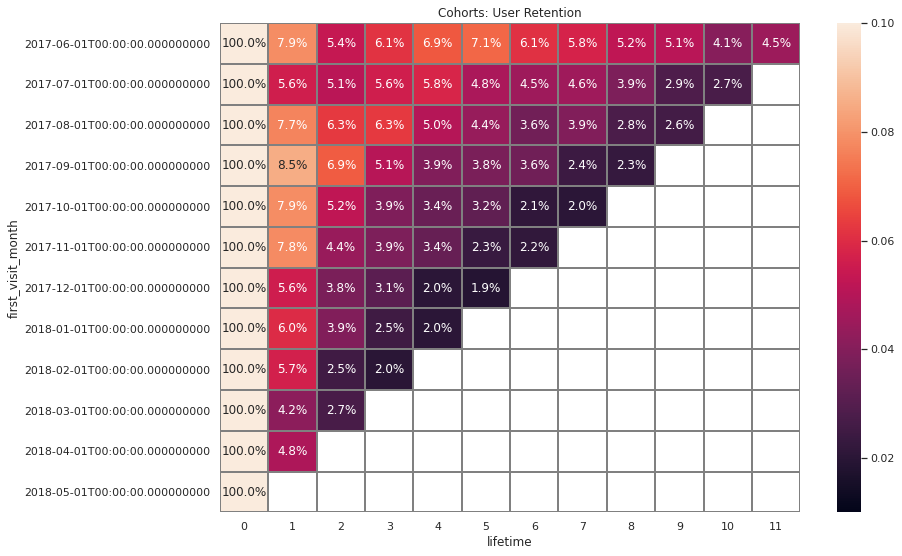

In [34]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(visits_retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0.01, vmax=0.1); 


### Метрики электронной коммерции

#### Среднее время от первого посещения сайта до первой покупки

Рассчитаем, сколько в среднем времени проходит от первого посещения сайта до первой покупки

In [35]:
#посчитаем время первого захода на сайти и время первой покупки
first_session = visits.groupby('uid')['start_ts'].min()
first_session.name = 'first_session'
visits = pd.merge(visits,first_session,on='uid')
first_order = orders.groupby('uid')['buy_ts'].min()
first_order.name = 'first_order'
orders_new = pd.merge(first_session,first_order,on='uid').reset_index()

#посчитаем разницу в секундах между первым заходом на сайт и первой покупкой
orders_new['delta_seconds'] = (orders_new['first_order'] - orders_new['first_session']).dt.seconds
display(orders_new.head())

uid       first_session         first_order  delta_seconds
0   313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00          82920
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00              0
2  2429014661409475 2017-10-11 17:14:00 2017-10-11 18:33:00           4740
3  2464366381792757 2018-01-27 20:10:00 2018-01-28 15:54:00          71040
4  2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00              0

In [36]:
orders_new['delta_seconds'].value_counts().head(10)

60     2669
0      2467
120    2123
180    1700
240    1474
300    1216
360    1088
420     985
480     809
540     766
Name: delta_seconds, dtype: int64

In [37]:
orders_new.describe()

uid  delta_seconds
count  3.652300e+04   36523.000000
mean   9.213152e+18   14949.881445
std    5.324792e+18   25784.567076
min    3.135781e+14       0.000000
25%    4.615081e+18     240.000000
50%    9.245161e+18     960.000000
75%    1.383709e+19   15120.000000
max    1.844617e+19   86340.000000

<b> Для наглядности построим диаграмму </b>

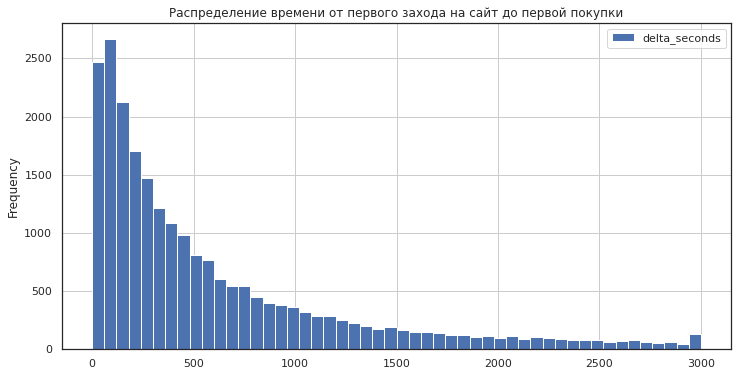

In [38]:
orders_new.plot(y ='delta_seconds', kind = 'hist', bins = 50, grid = True, figsize = (12, 6), range = (0, 3000)) 
plt.title('Распределение времени от первого захода на сайт до первой покупки')
plt.show()


Таким образом, мы видим, что большинству пользователей хватает 60 секунд для совешения заказа, медианное время - 960 секунд

#### Среднее количество покупок на одного покупателя за период

In [39]:
#найдем первый месяц покупки каждого покупателя:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid')['order_month'].min().reset_index()
first_orders.columns = ['uid', 'first_order_month']
#display(first_orders.head()) 

#посчитаем количество новых покупателей (n_buyers) за каждый месяц:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
#display(cohort_sizes.head()) 

#построим когорты и добавим месяц первой покупки каждого покупателя в таблицу с заказами:
orders_new = pd.merge(orders,first_orders, on='uid')
#display(orders_new.head())
        
#сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку:
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': ['sum', 'count']}).reset_index()
#display(cohorts.head())

#добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#display(report)
report.columns = ['first_order_month', 'n_buyers', 'order_month', 'revenue_sum', 'revenue_count']

#посчитаем возраст когорты
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
#display(report)
 
report['orders_per_buyer'] = report[('revenue_count')] / report['n_buyers']
 
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='orders_per_buyer', 
        aggfunc='mean'
)
 
output.fillna('')
#сложим покупки каждого пользователя, чтобы посмотреть как менялась сумма
output = output.cumsum(axis=1).round(2) 
display(output)

age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         1.16  1.25  1.34  1.45  1.59  1.70  1.84  1.92  2.03  2.10   
2017-07-01         1.14  1.19  1.25  1.31  1.34  1.39  1.42  1.44  1.47  1.49   
2017-08-01         1.12  1.20  1.27  1.33  1.39  1.44  1.47  1.53  1.56  1.60   
2017-09-01         1.14  1.22  1.28  1.35  1.37  1.42  1.46  1.48  1.50   NaN   
2017-10-01         1.14  1.22  1.25  1.28  1.31  1.34  1.35  1.38   NaN   NaN   
2017-11-01         1.18  1.28  1.32  1.37  1.41  1.42  1.45   NaN   NaN   NaN   
2017-12-01         1.15  1.21  1.26  1.30  1.32  1.34   NaN   NaN   NaN   NaN   
2018-01-01         1.12  1.19  1.24  1.25  1.28   NaN   NaN   NaN   NaN   NaN   
2018-02-01         1.12  1.18  1.21  1.22   NaN   NaN   NaN   NaN   NaN   NaN   
2018-03-01         1.17  1.22  1.27   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-04-01         1.10  1.18   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-05-01         1.09   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-06-01         1.00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

age                  10    11  
first_order_month              
2017-06-01         2.15  2.19  
2017-07-01         1.51   NaN  
2017-08-01          NaN   NaN  
2017-09-01          NaN   NaN  
2017-10-01          NaN   NaN  
2017-11-01          NaN   NaN  
2017-12-01          NaN   NaN  
2018-01-01          NaN   NaN  
2018-02-01          NaN   NaN  
2018-03-01          NaN   NaN  
2018-04-01          NaN   NaN  
2018-05-01          NaN   NaN  
2018-06-01          NaN   NaN

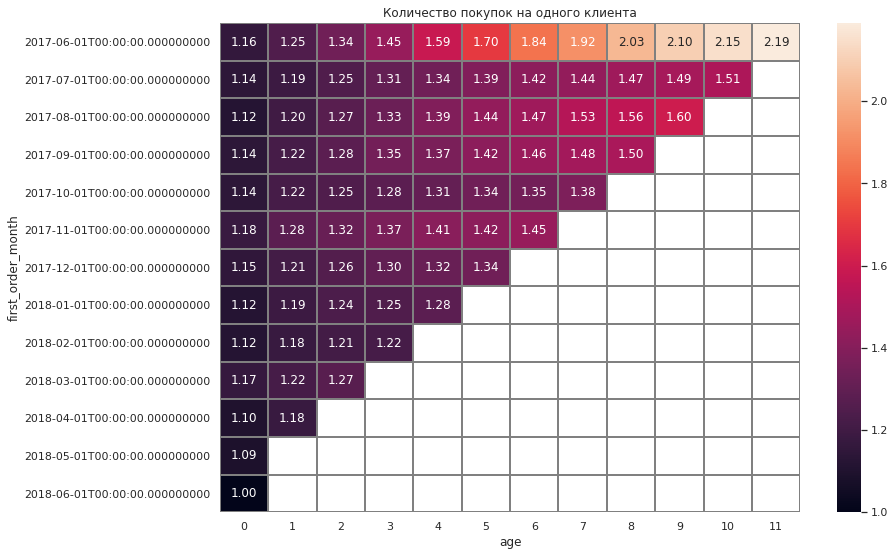

In [40]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Количество покупок на одного клиента')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

Таким образом, у нас получается примерно 1,5 покупки на 1 человека за 6 месяцев

#### Расчет среднего чека

In [41]:
#откроем таблицу orders
orders.head()

buy_ts  revenue                   uid order_month
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01

In [42]:
mean_revenue = orders['revenue'].mean()
print('Сумма среднего чека составляет', mean_revenue, 'у.е')

Сумма среднего чека составляет 4.999646930477041 у.е


In [43]:
orders.describe()

revenue           uid
count  50415.000000  5.041500e+04
mean       4.999647  9.098161e+18
std       21.818359  5.285742e+18
min        0.000000  3.135781e+14
25%        1.220000  4.533567e+18
50%        2.500000  9.102274e+18
75%        4.890000  1.368290e+19
max     2633.280000  1.844617e+19

Посмотрим на распределение средней стоимости по месяцам:

In [44]:
#display(orders_new.head())

orders_new.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='revenue',
    aggfunc='mean',
) 


order_month        2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
first_order_month                                                               
2017-06-01           4.060106    5.547006    5.088161    8.545575    7.084178   
2017-07-01                NaN    5.287123    6.446100    9.992083    6.637596   
2017-08-01                NaN         NaN    4.715479    5.987315    6.281200   
2017-09-01                NaN         NaN         NaN    4.967109   13.171187   
2017-10-01                NaN         NaN         NaN         NaN    4.374738   
2017-11-01                NaN         NaN         NaN         NaN         NaN   
2017-12-01                NaN         NaN         NaN         NaN         NaN   
2018-01-01                NaN         NaN         NaN         NaN         NaN   
2018-02-01                NaN         NaN         NaN         NaN         NaN   
2018-03-01                NaN         NaN         NaN         NaN         NaN   
2018-04-01                NaN         NaN         NaN         NaN         NaN   
2018-05-01                NaN         NaN         NaN         NaN         NaN   
2018-06-01                NaN         NaN         NaN         NaN         NaN   

order_month        2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
first_order_month                                                               
2017-06-01           6.825321    6.966449    6.761839    5.279009    8.009869   
2017-07-01           4.721806    3.659512    3.789508    5.454400    5.345690   
2017-08-01           6.617901    7.962941    6.265323    5.890000    7.113590   
2017-09-01           8.351056   62.570244   15.430448   15.321835   16.767130   
2017-10-01           7.405127    5.127469    5.590246    5.098992    5.071553   
2017-11-01           4.370717    4.103955    4.474670    6.284976    4.441471   
2017-12-01                NaN    4.110746    4.226741   20.072772   26.084358   
2018-01-01                NaN         NaN    3.687417    4.438482    6.454969   
2018-02-01                NaN         NaN         NaN    3.706266    4.576486   
2018-03-01                NaN         NaN         NaN         NaN    4.139344   
2018-04-01                NaN         NaN         NaN         NaN         NaN   
2018-05-01                NaN         NaN         NaN         NaN         NaN   
2018-06-01                NaN         NaN         NaN         NaN         NaN   

order_month        2018-04-01  2018-05-01  2018-06-01  
first_order_month                                      
2017-06-01          12.038125    6.042093         NaN  
2017-07-01          11.790000    5.648302         NaN  
2017-08-01           8.702826    5.598478         NaN  
2017-09-01          11.206607    7.785574         NaN  
2017-10-01           4.280233    4.009120         NaN  
2017-11-01           3.726780    4.598235         NaN  
2017-12-01          15.948488   14.111048         NaN  
2018-01-01           7.524844    2.711282         NaN  
2018-02-01           3.453735    3.867143         NaN  
2018-03-01           5.972191    6.334489         NaN  
2018-04-01           4.248774    6.204718         NaN  
2018-05-01                NaN    4.286168         NaN  
2018-06-01                NaN         NaN        3.42

- Максимальная средняя стоимость по первым трем когортам была в апреле 2018 года,затем она начинает снижаться
- В четвертой когорте была самая максимальная средняя сумма покупок среди всех когорт - 62  у.е. в декабре 2017 года
- Все когорты. кроме последней прекратили свои покупки к июню 2018 года, при этом для последней когорты пользователей - это первый месяц покупок.
Возможно, в этот период были какие-то изменения сайта или товара.
    
    

#### Расчет LTV

Выясним, как меняется во времени LTV на покупателя по когортам. <p> 
Маржинальность сервиса — 100%.

In [45]:
margin_rate = 1
report['gp'] = report['revenue_sum'] * margin_rate
report['revenue_per_buyer'] = report['gp'] / report['n_buyers']
report['ltv'] = report['gp'] / report['n_buyers']
 
output_ltv = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='sum'
).cumsum(axis = 1)

 
output_ltv.fillna('')



age                      0         1         2          3          4   \
first_order_month                                                       
2017-06-01         4.724414  5.209743   5.64738   6.602051   7.624582   
2017-07-01         6.010218  6.345429   6.96896   7.327936   7.504727   
2017-08-01         5.276518  5.748511  6.206993    6.59827   7.092321   
2017-09-01         5.644529  6.762115  7.283045  11.258838  11.659396   
2017-10-01         5.003733  5.539495  5.730889   5.888035   6.039594   
2017-11-01         5.154683  5.553916  5.753472   6.078424   6.226437   
2017-12-01         4.738191  4.998565  5.923662   6.988937   7.301866   
2018-01-01         4.135636  4.430394  4.734675   4.877453   4.940151   
2018-02-01         4.156987  4.435262  4.513777   4.587921              
2018-03-01         4.838803  5.139694  5.455253                         
2018-04-01         4.657597  5.189196                                   
2018-05-01         4.660562                                             
2018-06-01         3.420000                                             

age                       5          6         7          8          9   \
first_order_month                                                         
2017-06-01          8.360084   9.310524  9.892116  10.445329  11.051117   
2017-07-01          7.660775   7.780983  7.922803   8.084035    8.23118   
2017-08-01          7.375861   7.586526  7.991533   8.283745   8.471723   
2017-09-01         12.306463  13.008071  13.25122  13.435227              
2017-10-01          6.159956   6.244772  6.360242                         
2017-11-01          6.280316   6.395244                                   
2017-12-01          7.639913                                              
2018-01-01                                                                
2018-02-01                                                                
2018-03-01                                                                
2018-04-01                                                                
2018-05-01                                                                
2018-06-01                                                                

age                       10         11  
first_order_month                        
2017-06-01         11.622378  11.879234  
2017-07-01          8.386854             
2017-08-01                               
2017-09-01                               
2017-10-01                               
2017-11-01                               
2017-12-01                               
2018-01-01                               
2018-02-01                               
2018-03-01                               
2018-04-01                               
2018-05-01                               
2018-06-01

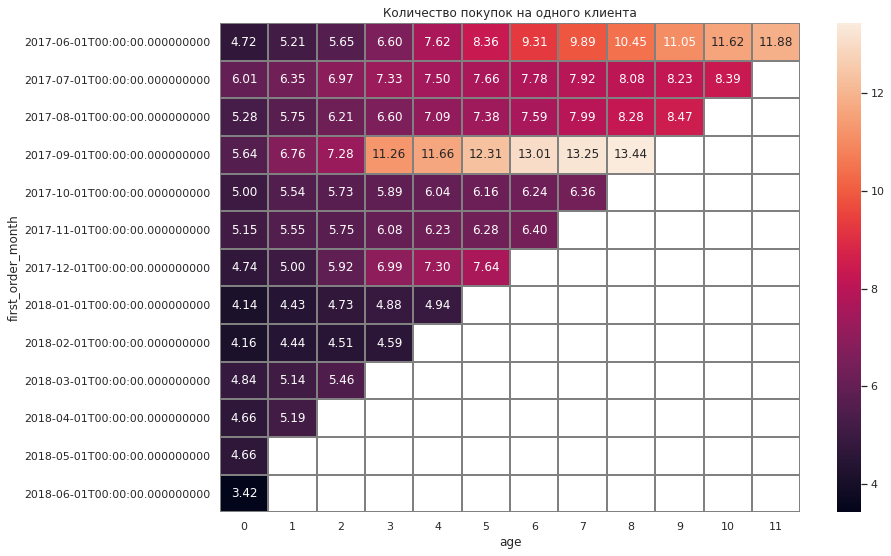

In [46]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Количество покупок на одного клиента')
sns.heatmap(output_ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

<b> Рассчитаем средний LTV по когортам за 6 месяцев </b>

In [47]:
output_ltv[5].mean()

7.969052630207336

Таким образом, из графика ltv можно сделать вывод: 
- Количество покупок на одного клиента с возрастом когорты растет, соответственно, с возрастом когорты растет и прибыль с одного клиента
- В некоторых когортах рост прибыли происходит быстрее, например, самые прибыльные когорты - 1 и 4. Среди них выделяется четвертая.
- Самый маленький прирост прибыли в 5, 7 и 7 когортах
- В целом, можно сделать вывод, что с поялвением новых когорт их прибыльность снижается

### Маркетинговые метрики

#### Расчет суммы расходов на маркетинг.

Рассчитаем сумму расходов на маркетинг, а так же как они распределены по рекламным источникам

In [48]:
#посмотрим на таблицу с расходами
display(costs.head())

source_id         dt  costs  session_week session_date
0          1 2017-06-01  75.20            22   2017-06-01
1          1 2017-06-02  62.25            22   2017-06-02
2          1 2017-06-03  36.53            22   2017-06-03
3          1 2017-06-04  55.00            22   2017-06-04
4          1 2017-06-05  57.08            23   2017-06-05

In [49]:
#проверим, какие источники расходов есть в нашей таблице
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

In [50]:
cost_sources = costs.groupby('source_id')['costs'].sum().reset_index()
display(cost_sources)

source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49

In [51]:
fig = px.bar(cost_sources, title='Расходы на маркетинг', y = 'costs', x ='source_id', color = 'costs')
fig.update_layout(
    xaxis_title='Ресурсы',
    yaxis_title='Сумма расходов'
    )
fig.show()

Из графика мы видим, что больше всего расходов компания потратила на маркетинг в источнике под номером 3, на втором месте расходы в 4м источнике. Источники 6 и 8 для маркетинга не использовались

#### Рассчитаем средний САС на одного покупателя

Рассчитаем САС для одного покупателя

Рассчитаем САС для покупателя первой когорты:

In [52]:
#отфильтруем нужную когорту
cohort_201706 = report[report['first_order_month'] == '2017-06-01']

#посчитаем расходы за этот месяц
costs_201706 = costs[costs['dt'] == '2017-06-01']['costs'].sum()

n_buyers_201706 = cohort_201706['n_buyers'][0]
cac_201706 = costs_201706 / n_buyers_201706
ltv_201706 = output_ltv.loc['2017-06-01'].sum()

print('CAC =', cac_201706)
print('LTV =', ltv_201706) 

CAC = 0.3634503213049926
LTV = 102.3689520514088


Привлечение одного покупателя из первой когорты обошлось компании в 0,36 у.е. Валовая прибыль с каждого покупателя - 13 у.е., т.е. вложение в привлечение покупателей окупились.

<b> Посчитаем остальные когорты </b>

In [53]:
#добавляем столбец с месяцем заказа
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs.head()

source_id         dt  costs  session_week session_date costs_month
0          1 2017-06-01  75.20            22   2017-06-01  2017-06-01
1          1 2017-06-02  62.25            22   2017-06-02  2017-06-01
2          1 2017-06-03  36.53            22   2017-06-03  2017-06-01
3          1 2017-06-04  55.00            22   2017-06-04  2017-06-01
4          1 2017-06-05  57.08            23   2017-06-05  2017-06-01

In [54]:
#посчитаем сумму расходов
costs_months = costs.groupby('costs_month')['costs'].sum().reset_index()
costs_months

costs_month     costs
0   2017-06-01  18015.00
1   2017-07-01  18240.59
2   2017-08-01  14790.54
3   2017-09-01  24368.91
4   2017-10-01  36322.88
5   2017-11-01  37907.88
6   2017-12-01  38315.35
7   2018-01-01  33518.52
8   2018-02-01  32723.03
9   2018-03-01  30415.27
10  2018-04-01  22289.38
11  2018-05-01  22224.27

In [55]:
#объединим данные по когортам с затратами
cac = pd.merge(cohort_sizes, costs_months, left_on = 'first_order_month', right_on = 'costs_month')
#cac.head()

#посчитаем САС
cac['cac'] = cac['costs'] / cac['n_buyers']
cac.head()

first_order_month  n_buyers costs_month     costs        cac
0        2017-06-01      2023  2017-06-01  18015.00   8.905091
1        2017-07-01      1923  2017-07-01  18240.59   9.485486
2        2017-08-01      1370  2017-08-01  14790.54  10.796015
3        2017-09-01      2581  2017-09-01  24368.91   9.441654
4        2017-10-01      4340  2017-10-01  36322.88   8.369327

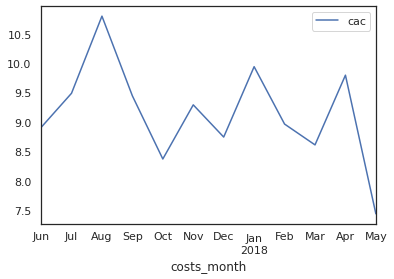

In [56]:
cac.plot(x = 'costs_month', y = 'cac')
plt.show()

Из графика мы видим, что самые высокие расходы на привлечение клиентов были в августе 2018, на втором месте - апрель 2018 года. С апреля 2018 года стоимость привлечения клиента резко снижается.

#### Рассчитаем ROMI в разрезе источников

In [57]:
#посмотрим визиты пользователей по первому заходу
users = visits.sort_values('start_ts').groupby('uid').first()
users.head()

device              end_ts  source_id            start_ts  \
uid                                                                           
11863502262781     touch 2018-03-01 17:33:00          3 2018-03-01 17:27:00   
49537067089222     touch 2018-02-06 15:57:00          2 2018-02-06 15:55:00   
297729379853735  desktop 2017-06-07 18:48:00          3 2017-06-07 18:47:00   
313578113262317  desktop 2017-09-18 23:07:00          2 2017-09-18 22:49:00   
325320750514679  desktop 2017-09-30 14:38:00          5 2017-09-30 14:29:00   

                 session_year  session_month  session_week session_date  \
uid                                                                       
11863502262781           2018              3             9   2018-03-01   
49537067089222           2018              2             6   2018-02-06   
297729379853735          2017              6            23   2017-06-07   
313578113262317          2017              9            38   2017-09-18   
325320750514679          2017              9            39   2017-09-30   

                 session_duration_sec       first_session  
uid                                                        
11863502262781                    360 2018-03-01 17:27:00  
49537067089222                    120 2018-02-06 15:55:00  
297729379853735                    60 2017-06-07 18:47:00  
313578113262317                  1080 2017-09-18 22:49:00  
325320750514679                   540 2017-09-30 14:29:00

In [58]:
#объединим таблицу с пользователями с таблицей
client = pd.merge(orders, users[['source_id']], on = 'uid', how = 'left')
client.head()

buy_ts  revenue                   uid order_month  source_id
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01          1
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01          2
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01          2
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01          2
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01          3

In [59]:
#для каждого пользователя считаем дату его первой покупки
client['first_order_ts'] = client.groupby('uid')['buy_ts'].transform('min')
client.head()

buy_ts  revenue                   uid order_month  source_id  \
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01          1   
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01          2   
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01          2   
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01          2   
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01          3   

       first_order_ts  
0 2017-06-01 00:10:00  
1 2017-06-01 00:25:00  
2 2017-06-01 00:27:00  
3 2017-06-01 00:29:00  
4 2017-06-01 07:58:00

In [60]:
#добавляем месяц первого заказа
client['first_order_month'] = client['first_order_ts'].astype('datetime64[M]')
client.head()

buy_ts  revenue                   uid order_month  source_id  \
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01          1   
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01          2   
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01          2   
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01          2   
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01          3   

       first_order_ts first_order_month  
0 2017-06-01 00:10:00        2017-06-01  
1 2017-06-01 00:25:00        2017-06-01  
2 2017-06-01 00:27:00        2017-06-01  
3 2017-06-01 00:29:00        2017-06-01  
4 2017-06-01 07:58:00        2017-06-01

In [61]:
#сгруппируем когорты с учетом ресурсов
cohort_source_sizes = client.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_source_sizes.columns = ['first_order_month', 'source_id', 'n_buyers']
cohort_source_sizes.head()

first_order_month  source_id  n_buyers
0        2017-06-01          1       190
1        2017-06-01          2       235
2        2017-06-01          3       638
3        2017-06-01          4       413
4        2017-06-01          5       384

In [62]:
#посчитаем сумму по доходам в когортах
source_cohorts = client.groupby(['first_order_month', 'order_month', 'source_id']).agg({'revenue' : 'sum'}).reset_index()
source_cohorts.columns = ['first_order_month', 'order_month','source_id', 'revenue']
source_cohorts.head()

first_order_month order_month  source_id  revenue
0        2017-06-01  2017-06-01          1  1378.70
1        2017-06-01  2017-06-01          2  1043.68
2        2017-06-01  2017-06-01          3  2804.34
3        2017-06-01  2017-06-01          4  1959.84
4        2017-06-01  2017-06-01          5  1898.89

In [63]:
#соединяем оба датафрейма
source_report = pd.merge(cohort_source_sizes, source_cohorts, on = ['first_order_month', 'source_id'])
source_report.head()


first_order_month  source_id  n_buyers order_month  revenue
0        2017-06-01          1       190  2017-06-01  1378.70
1        2017-06-01          1       190  2017-07-01   414.98
2        2017-06-01          1       190  2017-08-01   419.43
3        2017-06-01          1       190  2017-09-01   714.24
4        2017-06-01          1       190  2017-10-01   811.20

In [64]:
#определим возраст когорт
source_report['age'] = ((source_report['order_month'] - source_report['first_order_month']) / np.timedelta64(1,'M')).round().astype('int')
source_report.head()

first_order_month  source_id  n_buyers order_month  revenue  age
0        2017-06-01          1       190  2017-06-01  1378.70    0
1        2017-06-01          1       190  2017-07-01   414.98    1
2        2017-06-01          1       190  2017-08-01   419.43    2
3        2017-06-01          1       190  2017-09-01   714.24    3
4        2017-06-01          1       190  2017-10-01   811.20    4

In [65]:
#посчитаем LTV
source_report['ltv'] = source_report['revenue'] / source_report['n_buyers']
source_report.head()

first_order_month  source_id  n_buyers order_month  revenue  age       ltv
0        2017-06-01          1       190  2017-06-01  1378.70    0  7.256316
1        2017-06-01          1       190  2017-07-01   414.98    1  2.184105
2        2017-06-01          1       190  2017-08-01   419.43    2  2.207526
3        2017-06-01          1       190  2017-09-01   714.24    3  3.759158
4        2017-06-01          1       190  2017-10-01   811.20    4  4.269474

##### Посчитаем LTV по источникам 

In [66]:
source_ltv = source_report.pivot_table(
    index = ['first_order_month', 'source_id'],
    columns = 'age',
    values = 'ltv',
    aggfunc = 'sum'
).cumsum(axis = 1)

#посмотрим распредление по источникам в когорте август 2017
source_ltv.loc['2017-08-01'].fillna('')

age                                0         1         2          3   \
first_order_month source_id                                            
2017-08-01        1          7.493363  8.690619  9.700885  10.665664   
                  2          5.738862  6.674797  6.853089   7.103984   
                  3          5.078635  5.233412  5.521365   5.628338   
                  4          5.064970  5.233639  5.364556   5.631716   
                  5          5.050139  5.802361  6.634139   7.344472   
                  7          1.220000                                  
                  9          4.074918  4.273279  4.913934   5.145082   
                  10         4.997297  5.109459   5.43973              

age                                 4          5          6          7   \
first_order_month source_id                                               
2017-08-01        1          11.704956  12.371327  13.051504  15.708673   
                  2           7.619106   7.682195   7.803902   8.196992   
                  3           5.790386   5.839674   5.904125   5.996855   
                  4           5.778018   5.986805    6.06997   6.259497   
                  5           8.424167   9.018806   9.403917   9.650139   
                  7                                                       
                  9            5.19918   5.267049   5.403279    5.69377   
                  10                                           5.563514   

age                                 8          9  10 11  
first_order_month source_id                              
2017-08-01        1          17.901858  18.680619        
                  2           8.230163   8.314553        
                  3           6.075549   6.136469        
                  4           6.352249   6.475473        
                  5           9.887917  10.122472        
                  7                                      
                  9           5.774918   5.925246        
                  10                     5.654324

In [67]:
#считаем средний ltv для 6 месяца
ltv_source_6m = source_ltv.reset_index().groupby(['source_id'])[5].mean().reset_index()
ltv_source_6m.columns = ['source_id', 'ltv_6m']
ltv_source_6m


source_id     ltv_6m
0          1  12.011587
1          2  15.491555
2          3   5.730149
3          4   6.032379
4          5   9.345449
5          7        NaN
6          9   5.815051
7         10   3.930334

##### Посчитаем САС по источникам 

In [68]:
#откроем таблицу costs
costs.head()

source_id         dt  costs  session_week session_date costs_month
0          1 2017-06-01  75.20            22   2017-06-01  2017-06-01
1          1 2017-06-02  62.25            22   2017-06-02  2017-06-01
2          1 2017-06-03  36.53            22   2017-06-03  2017-06-01
3          1 2017-06-04  55.00            22   2017-06-04  2017-06-01
4          1 2017-06-05  57.08            23   2017-06-05  2017-06-01

In [69]:
#сгруппируем таблицу с затратами по месяцам и источникам 
monthly_costs_sources = costs.groupby(['costs_month', 'source_id']).agg({'costs':'sum'}).reset_index()

#объединим таблицу с затратами с таблицей, где мы рассчитывали ltv
report_romi = pd.merge(source_report, monthly_costs_sources, left_on=['first_order_month', 'source_id'], right_on=['costs_month', 'source_id'])
report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']
report_romi.head()

first_order_month  source_id  n_buyers order_month  revenue  age       ltv  \
0        2017-06-01          1       190  2017-06-01  1378.70    0  7.256316   
1        2017-06-01          1       190  2017-07-01   414.98    1  2.184105   
2        2017-06-01          1       190  2017-08-01   419.43    2  2.207526   
3        2017-06-01          1       190  2017-09-01   714.24    3  3.759158   
4        2017-06-01          1       190  2017-10-01   811.20    4  4.269474   

  costs_month    costs       cac  
0  2017-06-01  1125.61  5.924263  
1  2017-06-01  1125.61  5.924263  
2  2017-06-01  1125.61  5.924263  
3  2017-06-01  1125.61  5.924263  
4  2017-06-01  1125.61  5.924263

In [70]:
#выведем сводную таблицу сас в зависимости от источников рекламы
report_cac_pivot = report_romi.pivot_table(
        index=['first_order_month', 'source_id'], 
        columns='age', 
        values='cac', 
        aggfunc='sum'
).cumsum(axis = 1)
report_cac_pivot.head()


#посмотрим распредление cac в когорте декабрь 2017
report_cac_pivot.loc['2017-12-01'].fillna('')

age                                 0          1          2          3   \
first_order_month source_id                                               
2017-12-01        1           7.073112  14.146224  21.219335  28.292447   
                  2          12.855118  25.710236  38.565354  51.420472   
                  3          12.315505  24.631010  36.946515   49.26202   
                  4           5.577683  11.155367   16.73305  22.310733   
                  5           7.616757  15.233515  22.850272   30.46703   
                  9           5.437851  10.875702  16.313554  21.751405   
                  10          7.598353  15.196706                         

age                                 4          5  6  7  8  9  10 11  
first_order_month source_id                                          
2017-12-01        1          35.365559  42.438671                    
                  2          64.275591  77.130709                    
                  3          61.577525  73.893030                    
                  4          27.888417  33.466100                    
                  5          38.083787  45.700545                    
                  9          27.189256  32.627107                    
                  10                    22.795059

In [71]:
#считаем средний cac для 6 месяца
cac_source_6m = report_cac_pivot.reset_index().groupby(['source_id'])[5].mean().reset_index()
cac_source_6m.columns = ['source_id', 'cac']
cac_source_6m

source_id        cac
0          1  42.086208
1          2  75.475715
2          3  84.062142
3          4  42.249988
4          5  42.302725
5          9  29.019921
6         10  25.981275

###### Рассчитаем ROMI по источникам

In [72]:
#рассчитаем romi
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']
report_romi.head()

first_order_month  source_id  n_buyers order_month  revenue  age       ltv  \
0        2017-06-01          1       190  2017-06-01  1378.70    0  7.256316   
1        2017-06-01          1       190  2017-07-01   414.98    1  2.184105   
2        2017-06-01          1       190  2017-08-01   419.43    2  2.207526   
3        2017-06-01          1       190  2017-09-01   714.24    3  3.759158   
4        2017-06-01          1       190  2017-10-01   811.20    4  4.269474   

  costs_month    costs       cac      romi  
0  2017-06-01  1125.61  5.924263  1.224847  
1  2017-06-01  1125.61  5.924263  0.368671  
2  2017-06-01  1125.61  5.924263  0.372625  
3  2017-06-01  1125.61  5.924263  0.634536  
4  2017-06-01  1125.61  5.924263  0.720676

In [73]:
#выведем сводную таблицу romi в зависимости от источников рекламы
report_romi_pivot_new = report_romi.pivot_table(
        index=['first_order_month', 'source_id'], 
        columns='age', 
        values='romi', 
        aggfunc='sum'
).round(2).cumsum(axis = 1)
report_romi_pivot_new.head()


age                            0     1     2     3     4     5     6     7   \
first_order_month source_id                                                   
2017-06-01        1          1.22  1.59  1.96  2.59  3.31  3.66  4.10  4.53   
                  2          0.43  0.48  0.51  0.70  0.86  0.95  1.11  1.25   
                  3          0.36  0.37  0.39  0.42  0.44  0.46  0.47  0.47   
                  4          0.56  0.56  0.58  0.63  0.76  0.93  1.10  1.13   
                  5          0.73  0.86  0.93  1.06  1.16  1.20  1.33  1.42   

age                            8     9     10    11  
first_order_month source_id                          
2017-06-01        1          4.91  5.19  5.39  5.67  
                  2          1.38  1.45  1.58  1.62  
                  3          0.47  0.47  0.47  0.47  
                  4          1.16  1.25  1.40  1.41  
                  5          1.50  1.64  1.66  1.68

In [74]:
#считаем средний romi для 6 месяца
romi_source_6m = report_romi_pivot_new.reset_index().groupby(['source_id'])[5].mean().reset_index()
romi_source_6m.columns = ['source_id', 'romi']
romi_source_6m

source_id      romi
0          1  1.764286
1          2  1.228571
2          3  0.418571
3          4  0.901429
4          5  1.391429
5          9  1.215714
6         10  0.756667

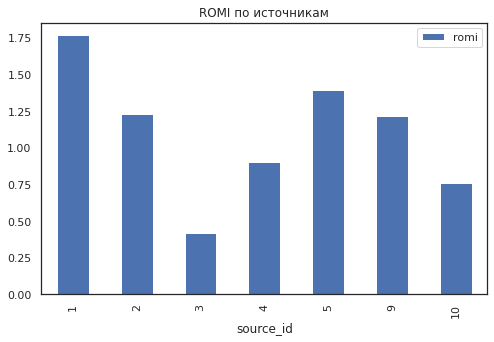

In [75]:
romi_source_6m.plot(y='romi', x='source_id', kind='bar', figsize=(8, 5), title='ROMI по источникам')
plt.show()

Исходя из диаграммы выше, можно сделать вывод, что самыми перспективными источниками для рекламы являются источники под номером 1 и 5.

In [76]:
report_for = report_romi.groupby(['first_order_month','source_id']).agg({'romi':'sum'}).reset_index()
#display(report_for)
#report_for.info()

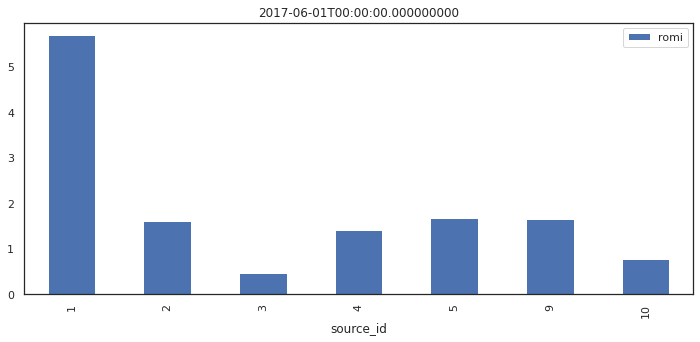

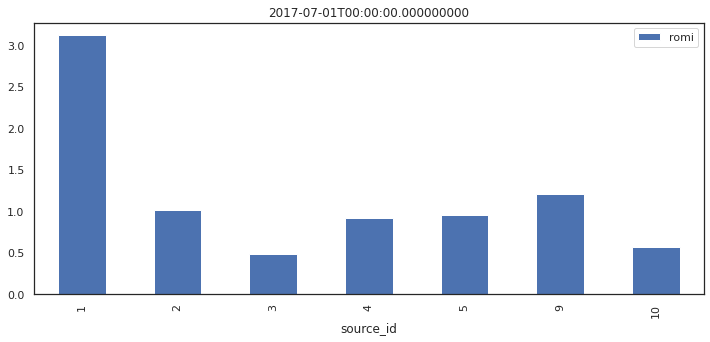

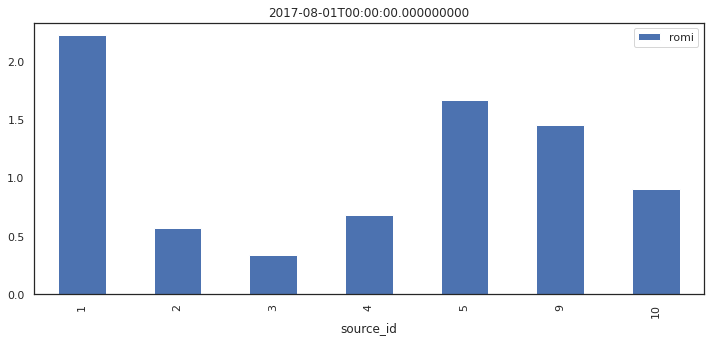

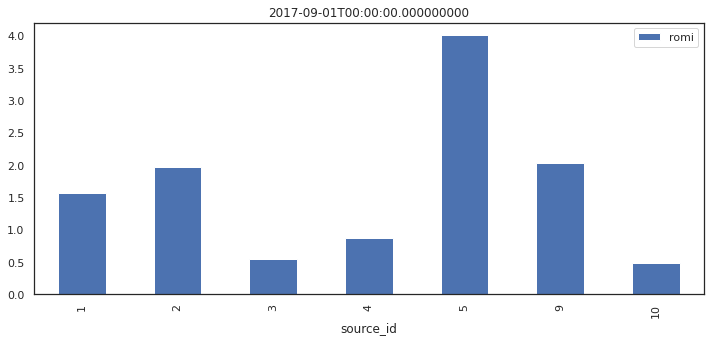

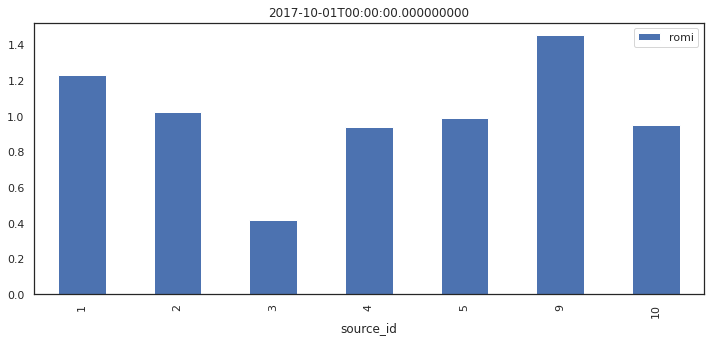

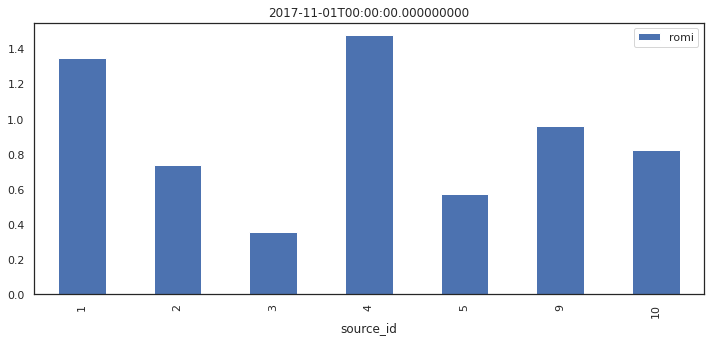

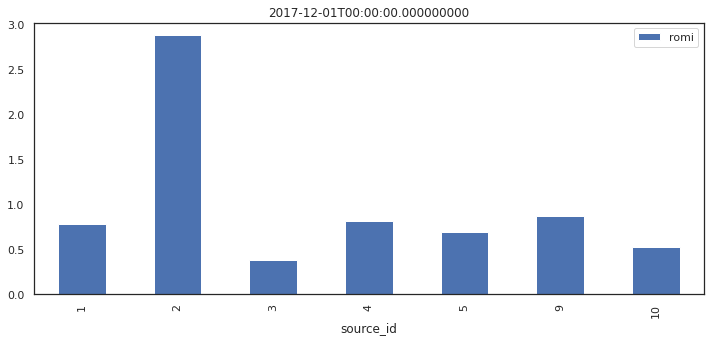

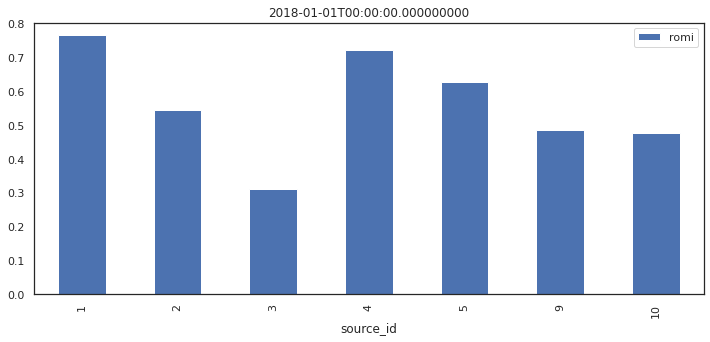

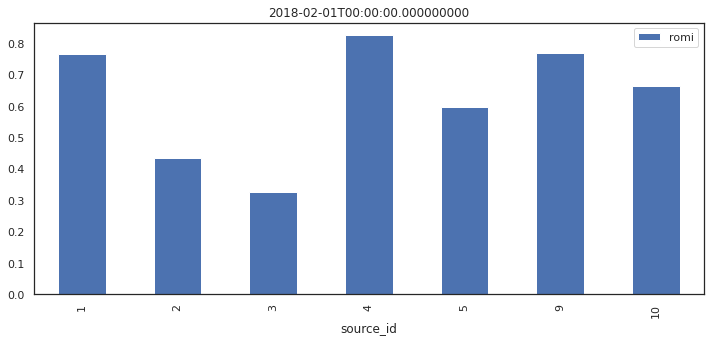

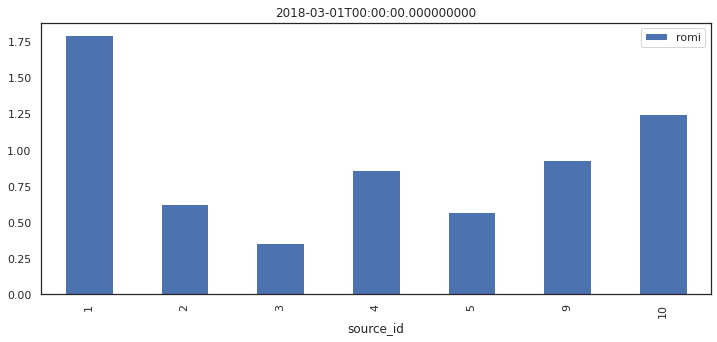

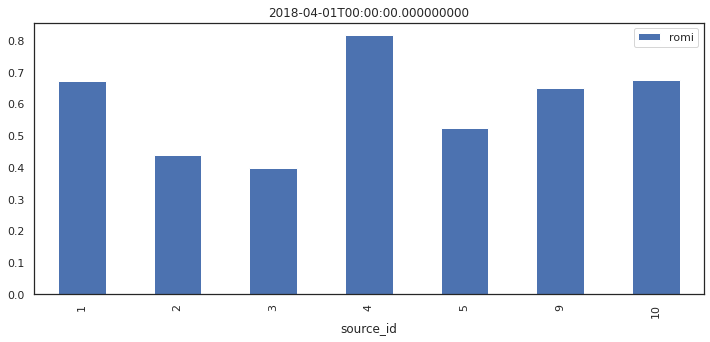

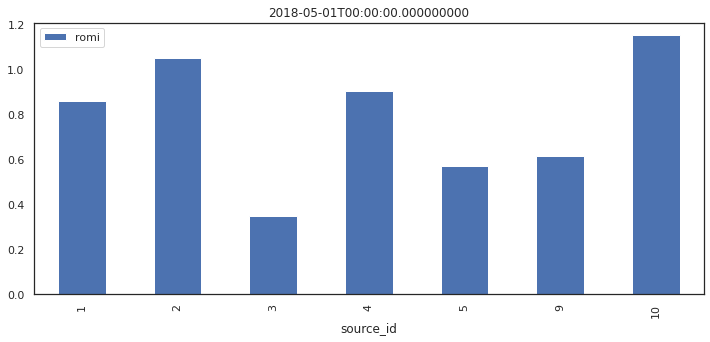

In [77]:
#создадим спиок с когортами
romi_list = report_romi['first_order_month'].unique()

#напишем цикл, который для каждого названия платформы построит график
for cohort_name in romi_list:
    report_for[report_for['first_order_month'] == cohort_name].plot(x='source_id', y='romi', kind='bar', title = cohort_name, figsize = (12,5))

Из графиков мы видим, на приход пользователей вылияли разные источники. Для первой, второй и третьей когорты - это источник под номером 1, он оказался самым прибыльным. Для четвертой и пятой когорты - источник под номером 5.
В целом, исходя из того, что коэффициент удержания пользователей разный прибыльность когорт разная, можно предоположить, что и целевая аудитория для этих рекламных источников тоже разная. Возможно, важно исползовать источник под номером один, поскольку оттуда приходят люди, которые остаются надолго.

## Шаг 3. Выводы и рекомендации

### Определение перспективных источников траффика

In [78]:
print('За весь период на рекламу потрачено', costs['costs'].sum())

За весь период на рекламу потрачено 329131.62


Мы определили, что за весь период на маркетинг потрачено 329131.62 у.е., но не все источники рекламы были одинаково результативны. Из графика по распределению трат по источникам можно сделать вывод, что потратила средства на под номером 3, на втором месте расходы в 4м источнике. Источники 6, 7 и 8 для маркетинга не использовались.
Так же из графиков ROMI по источникам мы видим, что самыми перспективными являются источники под номерами 1 и 5.

In [79]:
fig = px.bar(cost_sources, title='Расходы на маркетинг', y = 'costs', x ='source_id', color = 'costs')
fig.update_layout(
    xaxis_title='Ресурсы',
    yaxis_title='Сумма расходов'
    )
fig.show()

Для наглядности посмотрим распределение ROMI по источникам

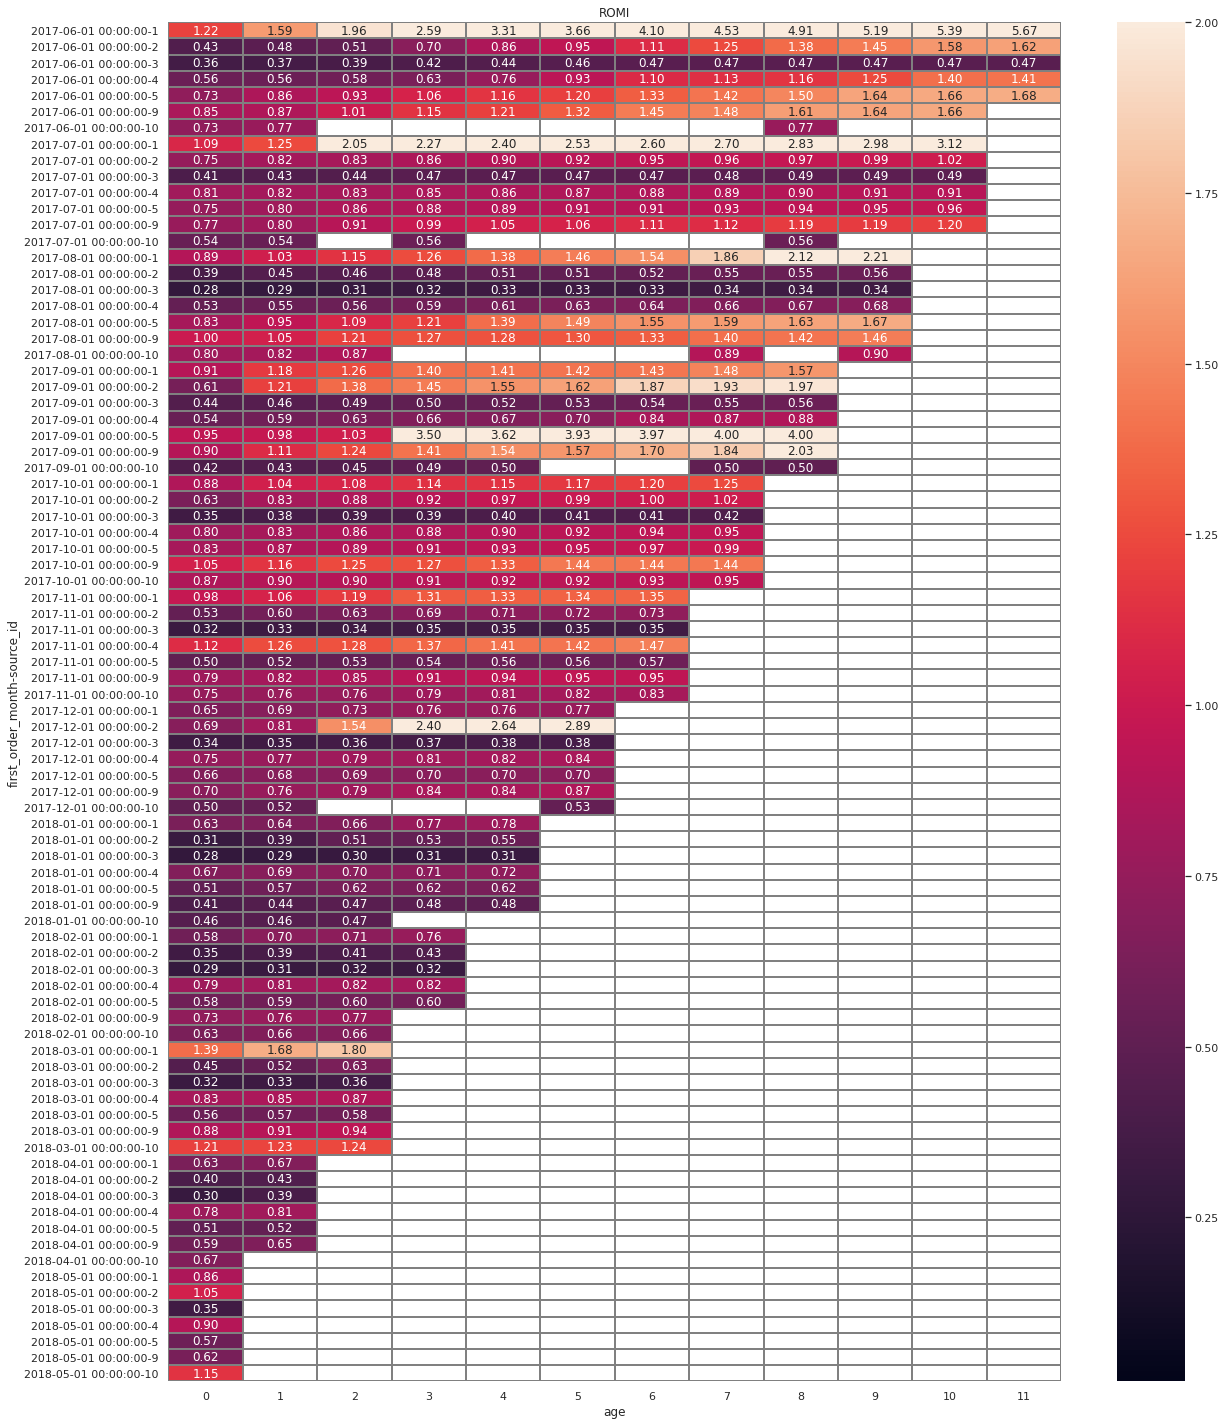

In [80]:
sns.set(style='white')
plt.figure(figsize=(20, 25))
plt.title('ROMI')
sns.heatmap(report_romi_pivot_new, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0.01, vmax=2); 

Из графика выше также видно, что самый выгодные источники для рекламы - под номером 1 и 5, когорты с ним окупаются быстрее.

### Выводы по метрикам

В данной работе мы проанализировали несколько метрик и можем сделать следующие выводы:    

1. По продуктовым метрикам:
- оценили DAU, WAU и MAU и определили, что количество пользователей росло до ноября 2017 года, после этого количество пользователей начинает снижаться.
- оценили среднее количество заходов на сайт для одного пользователя и определили, что оно колеблется между 1,2 - 1,3. Это немного, т.е. пользователь обычно успевать сделать заказ в течение первого посещения сайта или же в течение первого же посещения теряет интерес и больше не заходит.
- проанализировали среднюю продолжительность посещения сайта пользователем, метрика ASL   - 644 секунды; в целом, по нашему графику, наибольший объем пользователей укладывается в 500 секунд, а пик  - самое часто встречающееся знаачение - это 60 секунд. Если пользователю достаточно этого времени, чтобы сделать заказ, то все в порядке.
- оценили метрику Retention Rate, где определили, что коэффициент удержания пользователя снижается с возрастом когорты, при этом самый лучший коэффициент удержания - у первых когорт.
2. По метрикам электронной коммерции:
- изучили среднее время от посещения сайта до первой покупки, чаще всего это 60 секунд, медианное время - 960 секунд
- оценили среднее количество покупок на одного пользователя. У нас получается примерно 1,5 покупки на 1 человека за 6 месяцев, при этом так же результаты первых когорт выше, чем результаты последних.
- проанализировали средний чек покупателя, выявив, что максимальная средняя стоимость по первым трем когортам была в апреле 2018 года,затем она начинает снижаться. В четвертой когорте была самая максимальная средняя сумма покупок среди всех когорт - 62  у.е. в декабре 2017 года. Все когорты. кроме последней прекратили свои покупки к июню 2018 года, при этом для последней когорты пользователей - это первый месяц покупок. Возможно, в этот период были какие-то изменения сайта или товара.
- Рассчитали LTV  и определили среднюю прибыль, которую приносит пользователь компании  7.96 у.е.
3. По маркетинговым метрикам:
- посчитали сумму расходов на маркетинг за весь период и по месяцам, определив, что самые перспективные  источники под номерами 1 и 5.
- рассчитали средний САС на покупателя и определили, что за первые 6 месяцев существования когорт средняя сумма затрат по источникам превышает среднюю сумму прибыли по источникам, т.е. для того, чтобы когорта окупилась, необходимо больше 6 месяцев

### Итоги когортного анализа. Самые перспективные для компании когорты клиентов

In [81]:
#выведем сводную таблицу romi по когортам
report_romi_pivot_new_without_source = report_romi.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='sum'
).round(2).cumsum(axis = 1)
report_romi_pivot_new_without_source

age                  0     1     2     3     4      5      6      7      8   \
first_order_month                                                             
2017-06-01         4.88  5.50  6.14  7.31  8.50   9.27  10.30  11.01  11.77   
2017-07-01         5.11  5.44  6.44  6.87  7.13   7.32   7.48   7.63   7.87   
2017-08-01         4.72  5.14  5.65  5.99  6.36   6.58   6.78   7.28   7.62   
2017-09-01         4.76  5.96  6.48  9.41  9.79  10.25  10.83  11.14  11.48   
2017-10-01         5.41  6.00  6.24  6.42  6.60   6.79   6.88   7.01    NaN   
2017-11-01         5.00  5.35  5.59  5.96  6.12   6.18   6.28    NaN    NaN   
2017-12-01         4.28  4.56  5.40  6.38  6.64   6.96    NaN    NaN    NaN   
2018-01-01         3.27  3.49  3.74  3.89  3.93    NaN    NaN    NaN    NaN   
2018-02-01         3.96  4.24  4.30  4.37   NaN    NaN    NaN    NaN    NaN   
2018-03-01         5.64  6.07  6.38   NaN   NaN    NaN    NaN    NaN    NaN   
2018-04-01         3.90  4.17   NaN   NaN   NaN    NaN    NaN    NaN    NaN   
2018-05-01         5.49   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN   

age                   9      10     11  
first_order_month                       
2017-06-01         12.39  12.92  13.27  
2017-07-01          8.06   8.26    NaN  
2017-08-01          7.82    NaN    NaN  
2017-09-01           NaN    NaN    NaN  
2017-10-01           NaN    NaN    NaN  
2017-11-01           NaN    NaN    NaN  
2017-12-01           NaN    NaN    NaN  
2018-01-01           NaN    NaN    NaN  
2018-02-01           NaN    NaN    NaN  
2018-03-01           NaN    NaN    NaN  
2018-04-01           NaN    NaN    NaN  
2018-05-01           NaN    NaN    NaN

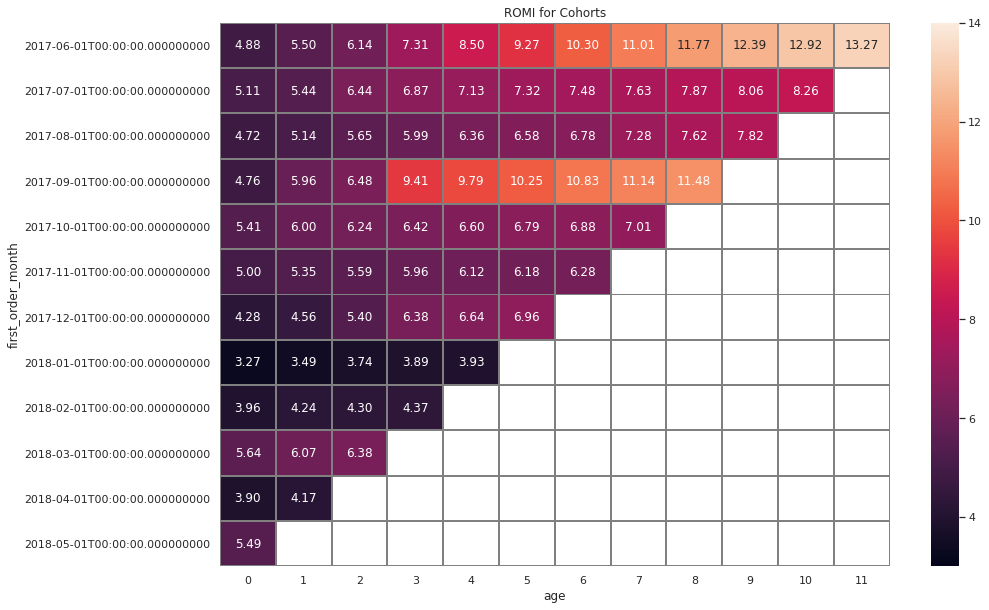

In [82]:
sns.set(style='white')
plt.figure(figsize=(15, 10))
plt.title('ROMI for Cohorts')
sns.heatmap(report_romi_pivot_new_without_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=3, vmax=14); 

Исходя из графика выше и из тех выводов, что мы сделали в п. 3., можно сделать, что самые перспективные для компании когорты - это 1,2,3 и 4. У них наиболее высокий ROMI

Исходя в целом из всего проекта, можно сделать следующие выводы:
- Количество визитов пользовтелей прямопропорционально влкадываемому бюджету на рекламу. Необлходимо недопускать резкого уменьшения трат на рекламу, поскольку это приводит к резкому снижению посещения сайта, и , соответственно, прибыли.
- Наиболее надежный ресурс для рекламы - источник под номером 1, с него приходили пользователи, которые остаются надолго и приносят наибольший доход компании.
- Так же хорошие результаты показывают 3 и 4 когорты, где использовался для рекламы источник 5, на него так же нужно сделать упор.
- Необходимо обратить внимание на уровень сервиса в компании, поскольку коэфффициент удержания пользователей в некоторых когортах сильно снижается со второго месяца жизни, возможно, в этот период происходит некое ухудшение обслуживания.
- Среднюю прибыль в 7,9 у.е. пользователь начинает приносить только к 6-7 месяцу обслуживания, поэтому важно обратить внимание на предыдущий пункт и попытаться увеличить коэффициент удержания пользователи - retention rate.